# Images classification using Deep Belief Network

In [120]:
import numpy as np

import random
np.random.seed(1337)  # for reproducibility

from scipy.io import loadmat

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.metrics.classification import accuracy_score
from sklearn.model_selection import train_test_split
from collections import namedtuple

from dbn.tensorflow import SupervisedDBNClassification

### Loading and preprocessing the data

In [92]:
# Import data from matlab .mat file
data_dir = 'data'
# dir for data files 16px and 28 pix
data_dir_16split = data_dir + '/caltech101_silhouettes_16_split1.mat'
data_dir_28split = data_dir + '/caltech101_silhouettes_28_split1.mat'

# define range of classes, between 1-101  
left = 1
right = 33

# data reads from .mat file are stored within dict list annots
annots = loadmat(data_dir_28split)

# Create list of all classes read from data file 
classnames = []
class_num_to_name = dict()
# a mapping dictionary from class number to its name
for i in range(left-1, right):
    classnames.append(annots['classnames'][0][i][0])
    class_num_to_name[i+1] = annots['classnames'][0][i][0]
    
print("Read keys stored within an annots dict:\n\n", annots.keys(), "\n")

# print("A list of", left,"-", right, "mapped classnames:\n")
# print(class_num_to_name)

Read keys stored within an annots dict:

 dict_keys(['__header__', '__version__', '__globals__', 'classnames', 'train_data', 'val_data', 'test_data', 'train_labels', 'val_labels', 'test_labels']) 



In [93]:
# function dat extract data with labels within range <left, right>
def get_proper_classes(data_name, label_name, left, right):
    data = list()
    labels = list()
    i = 0
    for img in annots[data_name]:
        if annots[label_name][i] <= right and annots[label_name][i] >= left:
            data.append(img)
            labels.append(annots[label_name][i])
        i += 1 
    data = np.array(data)
    labels = np.array(labels).flatten()
    return data, labels

In [94]:
# an image is represented by an array of 256 or 784 elements (16x16pix or 28x28pix)
train_data, train_labels = get_proper_classes('train_data', 'train_labels', left, right)
val_data, val_labels = get_proper_classes('val_data', 'val_labels', left, right)
test_data, test_labels = get_proper_classes('test_data', 'test_labels', left, right)

# simple check if each image has it's label
print("train_data shape:", train_data.shape, "train_labels shape:", train_labels.shape)
print("val_data shape:", val_data.shape, "val_labels shape:", val_labels.shape)
print("test_data shape:", test_data.shape, "test_labels shape:", test_labels.shape)

train_data shape: (1587, 784) train_labels shape: (1587,)
val_data shape: (1428, 784) val_labels shape: (1428,)
test_data shape: (1441, 784) test_labels shape: (1441,)


In [95]:
# function that counts quantity of images of each class
def count_images(dictionary, label_name, label):
    for x in label:
        dic_counts[label_name][x] = dic_counts[label_name].get(x) + 1 
    return dictionary 

In [96]:
# count number of images of each class within each label group
labels_names = ['train_labels', 'val_labels', 'test_labels']

# classes are within range
classes = [i for i in range(left, right+1)]

# create empty nested dictionaries to store quantity of each class img within each group
dic_counts = { label:{ class_id: 0 for class_id in classes} for label in labels}

# count number of occurences of each class within each group
dic_counts = count_images(dic_counts, 'train_labels', train_labels)
dic_counts = count_images(dic_counts, 'val_labels', val_labels)
dic_counts = count_images(dic_counts, 'test_labels', test_labels)
        
# print data
total =0
print("\033[1m{:<20}{:<10} {:<10} {:<10} {:<10} \033[0m".format('CLASS NAME', 'ID', 'TRAIN', "VAL", "TEST"))
for class_id in classes:
    print('{:<20}{:<10} {:<10} {:<10} {:<10}'.format(classnames[class_id-1], class_id, dic_counts['train_labels'][class_id],
                                                 dic_counts['val_labels'][class_id],
                                                 dic_counts['test_labels'][class_id]))
#     # restrict output rows to 10 elements
#     if class_id == 10:
#         print('{:<20}{:<10} {:<10} {:<10} {:<10}'.format("...", "...", "...", "...", "..."))
#         break
total = train_data.shape[0] + val_data.shape[0] + test_data.shape[0]
print("\ntotal number of elements:", total)

CLASS NAME          ID         TRAIN      VAL        TEST       
Airplanes Side 2    1          100        349        349       
Faces 2             2          100        167        168       
Faces 3             3          100        167        168       
Leopards            4          100        50         50        
Motorbikes 16       5          100        349        349       
accordion           6          33         11         11        
anchor              7          26         8          8         
ant                 8          26         8          8         
barrel              9          29         9          9         
bass                10         33         10         11        
beaver              11         28         9          9         
binocular           12         20         6          7         
bonsai              13         77         25         26        
brain               14         59         19         20        
brontosaurus        15         26      

Example of digit images of size: 28 x 28


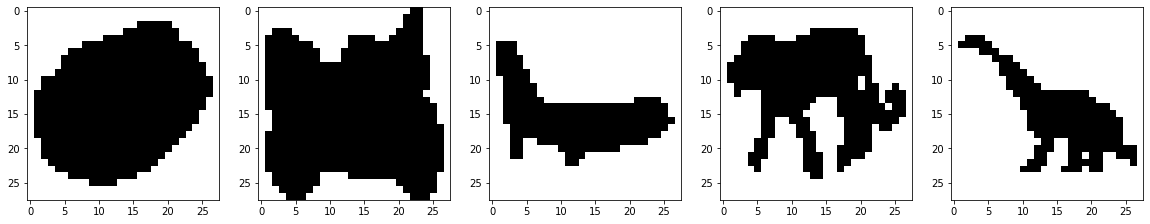

  brain                      Motorbikes 16            Airplanes Side 2          Leopards                  brontosaurus             


In [97]:
# displaying an exmaple images from a ndarray format
# set width and height, depends on read data
if annots['train_data'].shape[1] == 256:
    w, h = 16, 16
else:
    w, h = 28, 28

print("Example of digit images of size:", w, "x", h )
# an id's of 5 example images to be displayed, possible range: 'train_data' 0 - 4081, 'val_data' 0 - 2256, 'test_data' 0 - 2301 
# generate 5 random integers within proper range for chosen label
ids = [random.randint(0,train_data.shape[0]) for _ in range(5)]
images = []
for id in ids:
    image = train_data[id]
    # ndarray to store data that can be displayed, width x height x RGB
    data = np.zeros((h, w, 3), dtype = np.uint8)
    row = 0
    column = 0 
    for x in image:
        if x == 1:
            data[row, column]=[255, 255, 255]
        row += 1 
        if row == h:
            column += 1 
            row = 0
    images.append(data)
# matplot used to display an image
i = 1
rows = 1
columns = len(ids)
fig = plt.figure(figsize=(20,20))
for data in images:
    fig.add_subplot(rows, columns, i)
    plt.imshow(data, interpolation='nearest')
    i += 1 
plt.show()
class_examples = [classnames[train_labels[x]-1] for x in ids]
print('  {:<27}{:<25}{:<26}{:<26}{:<25}'.format(class_examples[0], class_examples[1], class_examples[2], class_examples[3], class_examples[4]))

## Building the model

In [129]:
# prepare structure store the results
Result = namedtuple('Result', 'h_structure, n_epochs batch_size learning_rate accuracy')
results = list()

In [126]:
# prepare input data
train_val = np.concatenate((train_data, val_data), axis=0).astype(np.float32)
labels_train_val = np.concatenate((train_labels, val_labels), axis=0)
#X_train, X_test, Y_train, Y_test = train_test_split(train, labels, test_size=0.2, random_state=0)

print("train data size:", train_val.shape) 
print("train labels size", labels_train_val.shape)
print("test data size:", test_data.shape)
print("test labels size:", test_labels.shape)

train data size: (3015, 784)
train labels size (3015,)
test data size: (1441, 784)
test labels size: (1441,)


In [147]:
# set the parameters:
hidden_layer_structure = [128,128]
n_epochs_rbm = 10
batch_size = 32
learning_rate = 0.1

In [148]:
# Training

classifier = SupervisedDBNClassification(hidden_layers_structure = hidden_layer_structure,
                                         learning_rate_rbm = learning_rate,
                                         learning_rate = 0.1,
                                         n_epochs_rbm = n_epochs_rbm,
                                         n_iter_backprop = 100,
                                         batch_size = batch_size,
                                         activation_function = 'relu',
                                         dropout_p = 0.2)
#classifier.fit(train_data, train_labels)
classifier.fit(train, labels)


# Test
test_pred = classifier.predict(test_data)
accuracy = accuracy_score(test_labels, test_pred)
print('Done.\nAccuracy: %f' % accuracy)
result = Result(hidden_layer_structure, n_epochs_rbm, batch_size, learning_rate, accuracy)
results.append(result)


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 424928.937500
>> Epoch 2 finished 	RBM Reconstruction error 322314.343750
>> Epoch 3 finished 	RBM Reconstruction error 461072.468750
>> Epoch 4 finished 	RBM Reconstruction error 401535.781250
>> Epoch 5 finished 	RBM Reconstruction error 444005.375000
>> Epoch 6 finished 	RBM Reconstruction error 394695.718750
>> Epoch 7 finished 	RBM Reconstruction error 372172.625000
>> Epoch 8 finished 	RBM Reconstruction error 433543.000000
>> Epoch 9 finished 	RBM Reconstruction error 484111.906250
>> Epoch 10 finished 	RBM Reconstruction error 600452.687500
>> Epoch 1 finished 	RBM Reconstruction error 81356193792.000000
>> Epoch 2 finished 	RBM Reconstruction error 81992835072.000000
>> Epoch 3 finished 	RBM Reconstruction error 73026723840.000000
>> Epoch 4 finished 	RBM Reconstruction error 60178399232.000000
>> Epoch 5 finished 	RBM Reconstruction error 71381319680.000000
>> Epoch 6 finished 	RBM Reconstruction error 6

In [149]:
for result in results:
    print("structure", result.h_structure, "epochs", result.n_epochs, "batch size:", result.batch_size, "learning rate:", result.learning_rate, "accuracy:", result.accuracy)

structure [256, 256] epochs 10 batch size: 32 learning rate: 0.1 accuracy: 0.7265787647467037
structure [256, 256] epochs 10 batch size: 64 learning rate: 0.1 accuracy: 0.24219292158223457
structure [256, 256] epochs 10 batch size: 48 learning rate: 0.1 accuracy: 0.6863289382373352
structure [256, 256] epochs 10 batch size: 16 learning rate: 0.1 accuracy: 0.6884108258154059
structure [784, 784] epochs 10 batch size: 32 learning rate: 0.1 accuracy: 0.732824427480916
structure [512, 512] epochs 10 batch size: 32 learning rate: 0.1 accuracy: 0.6835530881332408
structure [128, 128] epochs 10 batch size: 32 learning rate: 0.1 accuracy: 0.563497571131159
